In [1]:
import numpy as np
import time
import pyFAI
import matplotlib.pyplot as plt
# import pyopencl as cl
import fabio
from pyFAI.units import get_unit_fiber
import pandas as pd

/var/folders/8n/t90n3ysx17d4cf1385kk_jp80000gn/T/ipykernel_63599/2484121283.py:14: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(raw + 1e-6), cmap="viridis")


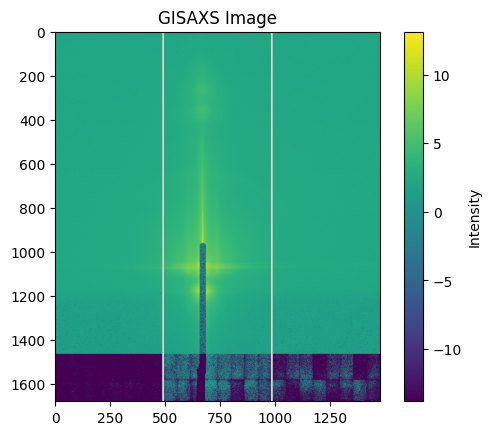

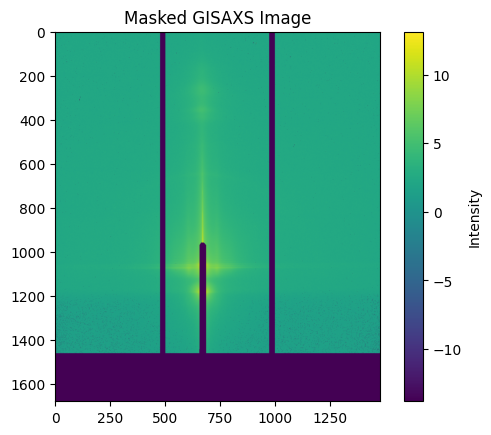

In [2]:
# Load raw image
raw = np.fromfile("comparison_with_pyFAI_equations_GISAXS/266_A0p160_A0p160_sfloat_2m.gb", dtype="<f4")
raw = raw.reshape((1679, 1475))

# Load and check mask
mask = fabio.open("comparison_with_pyFAI_equations_GISAXS/ALS_BCP_Mixing_2m_mask.tiff").data
assert mask.shape == raw.shape, "Mask and image shape mismatch"

# Correct mask application (keep where mask != 0)
masked_data = np.where(mask != 0, raw, 0)

# Show original
plt.figure()
plt.imshow(np.log(raw + 1e-6), cmap="viridis")
plt.colorbar(label="Intensity")
plt.title("GISAXS Image")
plt.show()

# Show masked
plt.figure()
plt.imshow(np.log(masked_data + 1e-6), cmap="viridis")
plt.colorbar(label="Intensity")
plt.title("Masked GISAXS Image")
plt.show()


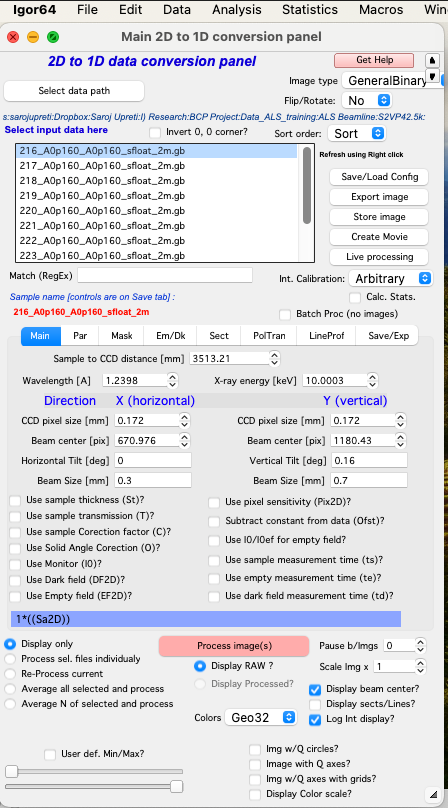

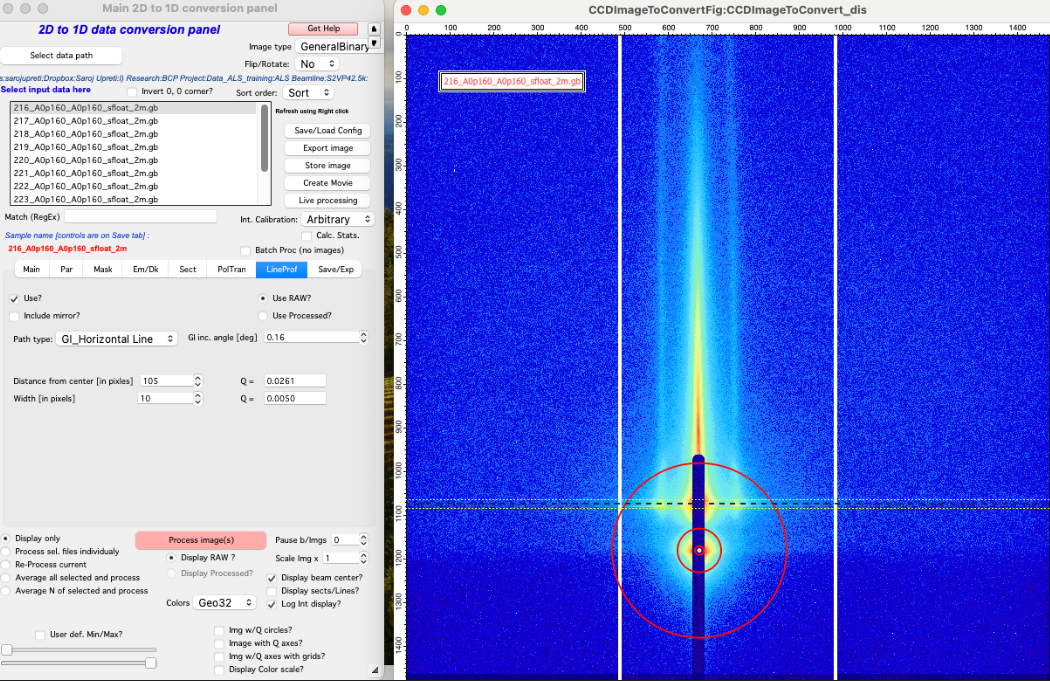

In [3]:
detector_image = masked_data.copy()

min qxy: -1.7548968999666728
max qxy: 1.2252807983739034
min qz: -1.7548968999666728
max qz: 1.2252807983739034


/var/folders/8n/t90n3ysx17d4cf1385kk_jp80000gn/T/ipykernel_63599/97093468.py:73: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(detector_image), cmap='viridis')  # No origin='lower', zero at top
/var/folders/8n/t90n3ysx17d4cf1385kk_jp80000gn/T/ipykernel_63599/97093468.py:86: RuntimeWarning: divide by zero encountered in log
  np.log(intensity_map),


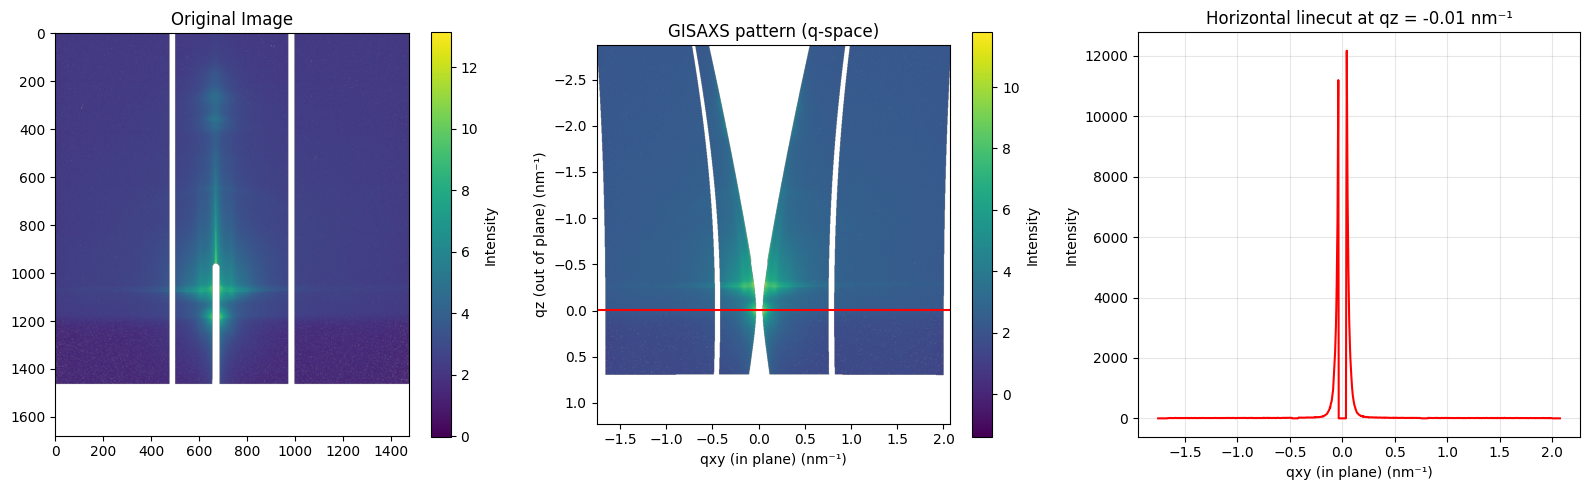

/var/folders/8n/t90n3ysx17d4cf1385kk_jp80000gn/T/ipykernel_63599/97093468.py:114: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(detector_image), cmap='viridis')  # No origin='lower'
/var/folders/8n/t90n3ysx17d4cf1385kk_jp80000gn/T/ipykernel_63599/97093468.py:127: RuntimeWarning: divide by zero encountered in log
  np.log(intensity_map),


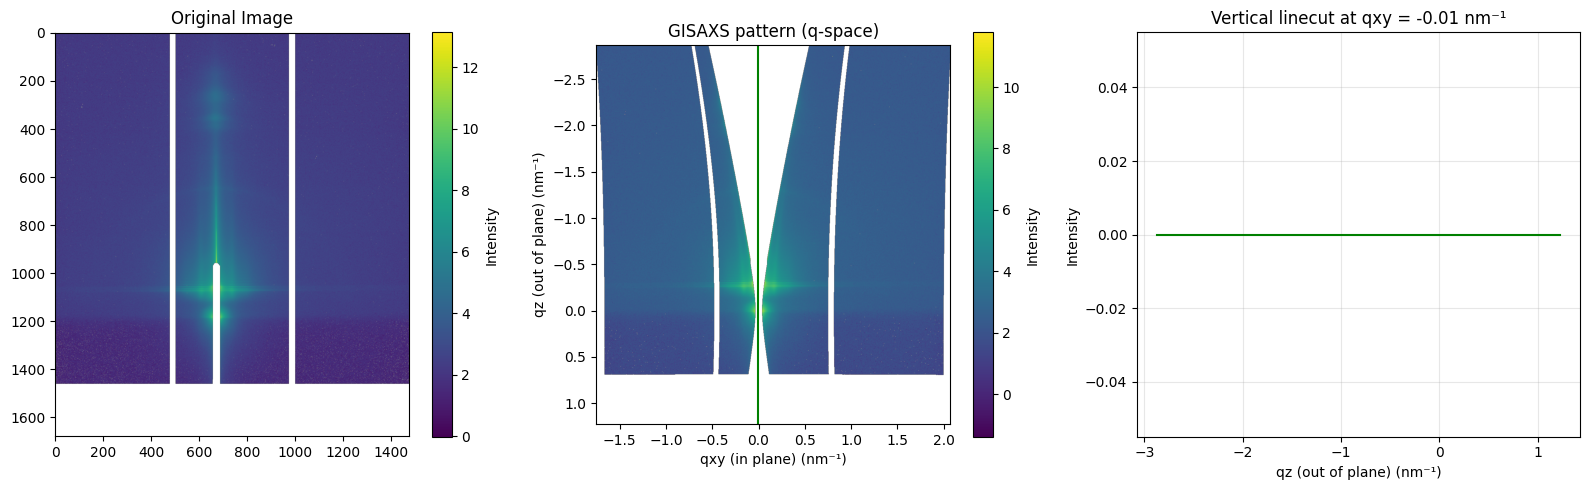

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from pyFAI.integrator.azimuthal import AzimuthalIntegrator


ai = AzimuthalIntegrator()

params = {
    'wavelength': 1.2398,  # X-ray wavelength in Angestrom (1.2398 Å)
    'sample_distance': 3513.21,  # Sample-to-detector distance in mm
    'beam_center_x': 670.976,  # Beam center x in pixels
    'beam_center_y': 1180.43,  # Beam center y in pixels
    'pixel_size_x': 172,  # Pixel size in micro meters (172 µm)
    'pixel_size_y': 172,  # Pixel size in micro meters (172 µm)
    'incident_angle': 0.16  # Incident angle in degrees
}

# Set beam geometry
# Convert meters to mm and µm where needed by PyFAI
ai.setFit2D(
    directDist=params['sample_distance'],  # mm
    centerX=params['beam_center_x'],  # pixels
    centerY=params['beam_center_y'],  # pixels
    tilt=0.0,
    tiltPlanRotation=0.0,
    pixelX=params['pixel_size_x'],  # µm
    pixelY=params['pixel_size_y'],  # µm
    wavelength=params['wavelength'],  # Å
)

# Promote to fiber integrator for GISAXS
fi = ai.promote(type_="pyFAI.integrator.fiber.FiberIntegrator")

result_2d = fi.integrate2d_grazing_incidence(data=detector_image, sample_orientation=1, incident_angle=0.16, tilt_angle=0.0)

# Extract the axes and intensity data
q_ip_values = result_2d.radial        # Horizontal axis
q_oop_values = result_2d.azimuthal    # Vertical axis
intensity_map = result_2d.intensity   # 2D intensity array

print("min qxy:", q_ip_values.min())
print("max qxy:", q_oop_values.max())

print("min qz:", q_ip_values.min())
print("max qz:", q_oop_values.max())

# Define target positions for linecuts
target_qz = 0  # Define your target qz value in nm^-1
target_qxy = 0  # Define your target qxy value in nm^-1

# Find indices
# qz_index = np.abs(q_ip_values - target_qz).argmin()
# qxy_index = np.abs(q_oop_values - target_qxy).argmin()

qz_index = np.where(np.abs(q_oop_values - target_qz) < 0.01)[0][0]
qxy_index = np.where(np.abs(q_ip_values - target_qxy) < 0.01)[0][0]

# What does argmin return?
# It returns the index of the minimum value in the array.
# In this case, it finds the index of the value in qz_values that is closest to target_qz
# and the index of the value in qxy_values that is closest to target_qxy.

# Extract linecuts
horizontal_cut = intensity_map[qz_index, :]  # Along qxy at fixed qz
vertical_cut = intensity_map[:, qxy_index]   # Along qz at fixed qxy


plt.figure(figsize=(16, 5))

# Original image with horizontal line
plt.subplot(1, 3, 1)
plt.imshow(np.log(detector_image), cmap='viridis')  # No origin='lower', zero at top
plt.colorbar(label='Intensity')
plt.title('Original Image')

# # Only plot if the y-pixel is within image bounds
# if 0 <= y_pixels < img_height:
#     plt.axhline(y=y_pixels, color='r', linestyle='-', linewidth=1.5)
# plt.xlabel('X pixel')
# plt.ylabel('Y pixel')

# Q-space image with horizontal line
plt.subplot(1, 3, 2)
plt.imshow(
    np.log(intensity_map),
    extent=[q_ip_values.min(), q_ip_values.max(), q_oop_values.max(), q_oop_values.min()],  # Flipped y axis
    cmap='viridis'  # Zero at top
)
plt.colorbar(label='Intensity')
plt.xlabel('qxy (in plane) (nm⁻¹)')
plt.ylabel('qz (out of plane) (nm⁻¹)')
plt.title('GISAXS pattern (q-space)')

# Add horizontal line showing the position of the linecut
plt.axhline(y=q_oop_values[qz_index], color='r', linestyle='-', linewidth=1.5)

# Horizontal linecut intensity plot
plt.subplot(1, 3, 3)
plt.plot(q_ip_values, horizontal_cut, 'r-')
plt.xlabel('qxy (in plane) (nm⁻¹)')
plt.ylabel('Intensity')
plt.title(f'Horizontal linecut at qz = {q_oop_values[qz_index]:.2f} nm⁻¹')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Figure 2: Vertical linecut visualization
plt.figure(figsize=(16, 5))

# Original image with vertical line
plt.subplot(1, 3, 1)
plt.imshow(np.log(detector_image), cmap='viridis')  # No origin='lower'
plt.colorbar(label='Intensity')
plt.title('Original Image')

# # Only plot if the x-pixel is within image bounds
# if 0 <= x_pixels_vertical < img_width:
#     plt.axvline(x=x_pixels_vertical, color='g', linestyle='-', linewidth=1.5)
# plt.xlabel('X pixel')
# plt.ylabel('Y pixel')

# Q-space image with vertical line
plt.subplot(1, 3, 2)
plt.imshow(
    np.log(intensity_map),
    extent=[q_ip_values.min(), q_ip_values.max(), q_oop_values.max(), q_oop_values.min()],  # Flipped y axis
    cmap='viridis'  # Zero at top
)
plt.colorbar(label='Intensity')
plt.xlabel('qxy (in plane) (nm⁻¹)')
plt.ylabel('qz (out of plane) (nm⁻¹)')
plt.title('GISAXS pattern (q-space)')

# Add vertical line showing the position of the linecut
plt.axvline(x=q_ip_values[qxy_index], color='g', linestyle='-', linewidth=1.5)

# Vertical linecut intensity plot - note the reversed y-axis
plt.subplot(1, 3, 3)
plt.plot(q_oop_values, vertical_cut, 'g-')
plt.ylabel('Intensity')
plt.xlabel('qz (out of plane) (nm⁻¹)')
# plt.gca().invert_yaxis()  # Invert y-axis to match the image orientation
plt.title(f'Vertical linecut at qxy = {q_ip_values[qxy_index]:.2f} nm⁻¹')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


k (wavevector magnitude): 50.6790 1/nm


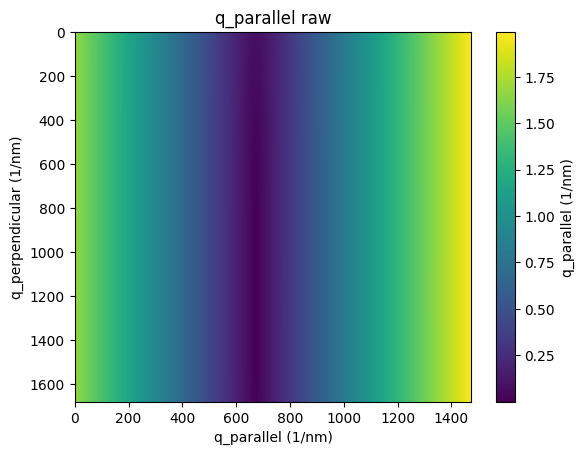

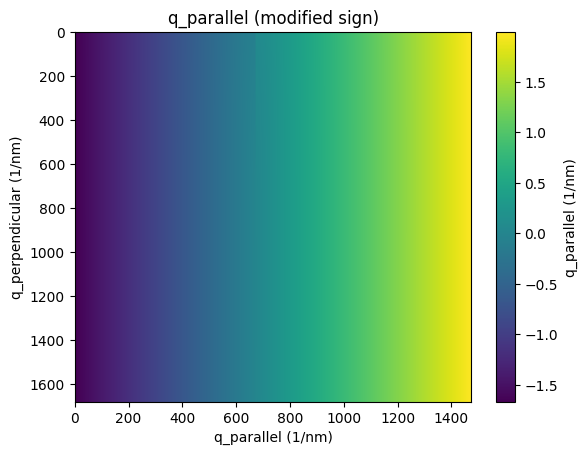

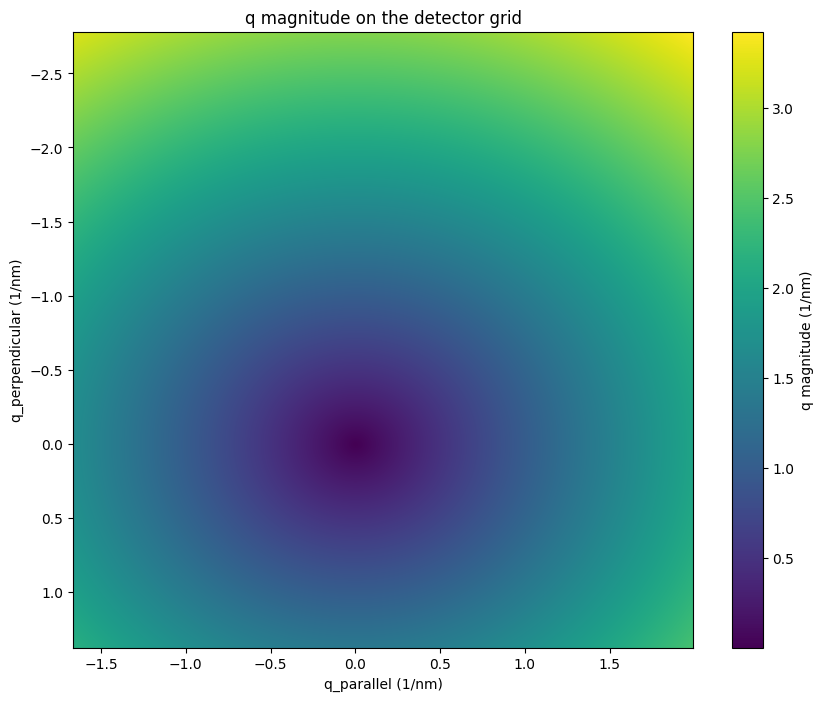

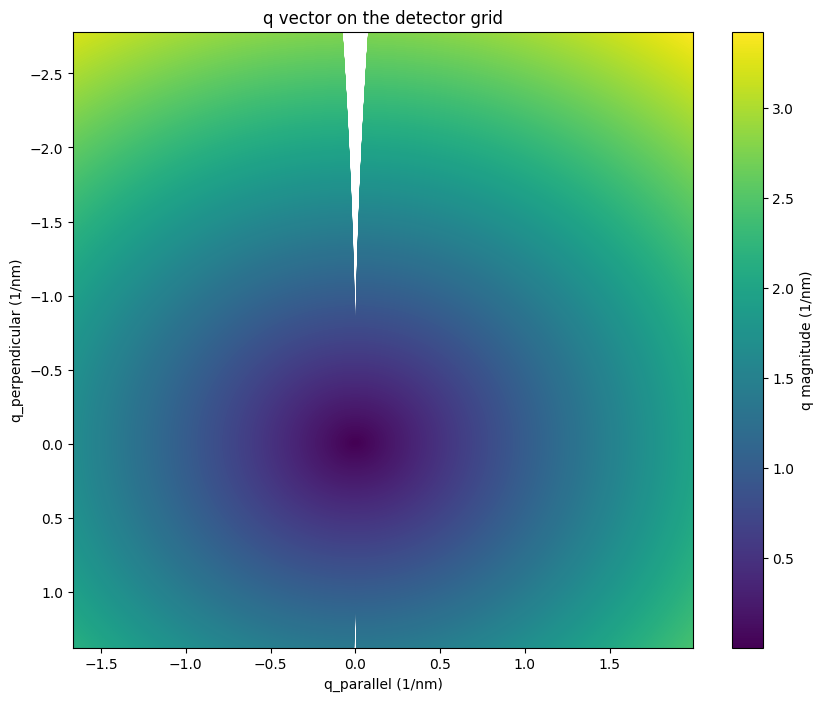

In [5]:
wavelength_nm = 0.12398  # X-ray wavelength in nm (1.2398 Å)

# Wavevector magnitude (1/nm)
k = 2 * np.pi / wavelength_nm
print(f"k (wavevector magnitude): {k:.4f} 1/nm")

# ==== Geometry setup ====

alpha_i_deg = 0.16
alpha_i = np.radians(alpha_i_deg)
psi_i = 0
psi_i = np.radians(psi_i)

# Detector setup
# det_dist_mm = 274.83
det_dist_mm = 3513.21
det_dist_m = det_dist_mm / 1000
pixel_size_mm = 0.172
pixel_size_m = pixel_size_mm / 1000

# Detector dimensions
nx, ny = 1475, 1679  # Detector dimensions in pixels
beam_center_x = 670.976  # Beam center x in pixels
beam_center_y = 1180.43  # Beam center y in pixels

# Create detector pixel grid (corrected to use beam center)
x = (np.arange(nx) - beam_center_x) * pixel_size_m
y = (np.arange(ny) - beam_center_y) * pixel_size_m
X, Y = np.meshgrid(x, y)

# Scattering angles
alpha_f = np.arctan2(Y, det_dist_m)
psi = np.arctan2(X, det_dist_m)

k_i_x = k * np.cos(alpha_i) * np.cos(psi_i)
k_i_y = k * np.cos(alpha_i) * np.sin(psi_i)
# k_i_x = k * np.cos(alpha_i)
# k_i_y = 0
k_i_z = k * -np.sin(alpha_i)
k_i_mag = np.sqrt(k_i_x**2 + k_i_y**2 + k_i_z**2)

k_f_x = k * np.cos(alpha_f) * np.cos(psi)
k_f_y = k * np.cos(alpha_f) * np.sin(psi)
k_f_z = k * np.sin(alpha_f)
k_f_mag = np.sqrt(k_f_x**2 + k_f_y**2 + k_f_z**2)

q_x = k_f_x - k_i_x
q_y = k_f_y - k_i_y
q_z = k_f_z - k_i_z

# q_x = np.cos(alpha_i) * (np.cos(alpha_f) * np.cos(psi)) + 0 + np.sin(alpha_i) * np.sin(alpha_f)
# q_y = np.cos(alpha_f) * np.sin(psi)
# q_z = np.sin(-alpha_i) * (np.cos(alpha_f) * np.cos(psi) - 1) + 0 + np.cos(alpha_i) * np.sin(alpha_f)

q_parallel_raw = np.sqrt(q_x**2 + q_y**2)
# q_parallel = q_parallel * np.sign(q_y)  # Ensure q_parallel has the same sign as q_y
q_perpendicular = q_z

plt.imshow(q_parallel_raw, aspect='auto')
plt.colorbar(label='q_parallel (1/nm)')
plt.title('q_parallel raw')
plt.xlabel('q_parallel (1/nm)')
plt.ylabel('q_perpendicular (1/nm)')
plt.show()
# make the sign of q_parallel the same as q_y
q_parallel = np.sqrt(q_x**2 + q_y**2) * np.sign(q_y)  # Ensure q_parallel has the same sign as q_y

plt.imshow(q_parallel, aspect='auto')
plt.colorbar(label='q_parallel (1/nm)')
plt.title('q_parallel (modified sign)')
plt.xlabel('q_parallel (1/nm)')
plt.ylabel('q_perpendicular (1/nm)')
plt.show()

q_mag = np.sqrt(q_x**2 + q_y**2 + q_z**2)

# Plot the detector grid
plt.figure(figsize=(10, 8))
plt.imshow(q_mag, extent=[q_parallel.min(), q_parallel.max(), q_perpendicular.max(), q_perpendicular.min()], aspect='auto')
plt.colorbar(label='q magnitude (1/nm)')
plt.title('q magnitude on the detector grid')
plt.xlabel('q_parallel (1/nm)')
plt.ylabel('q_perpendicular (1/nm)')
plt.show()

# Plot the q vector on the detector grid with color based on q magnitude
plt.figure(figsize=(10, 8))
# plt.scatter(q_parallel, q_perpendicular, s=1, c='blue', alpha=0.5)
plt.scatter(q_parallel, q_perpendicular, s=1, c=q_mag, cmap='viridis')
plt.colorbar(label='q magnitude (1/nm)')
plt.title('q vector on the detector grid')
plt.xlabel('q_parallel (1/nm)')
plt.ylabel('q_perpendicular (1/nm)')
plt.xlim(q_parallel.min(), q_parallel.max())
plt.ylim(q_perpendicular.max(), q_perpendicular.min())
plt.show()




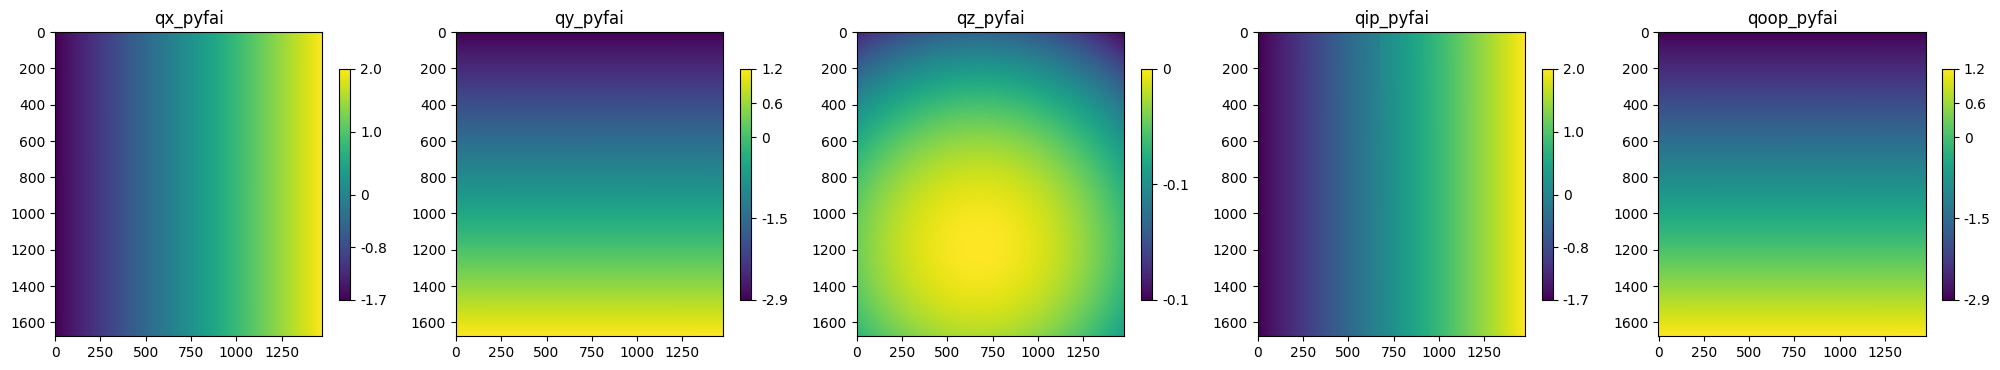

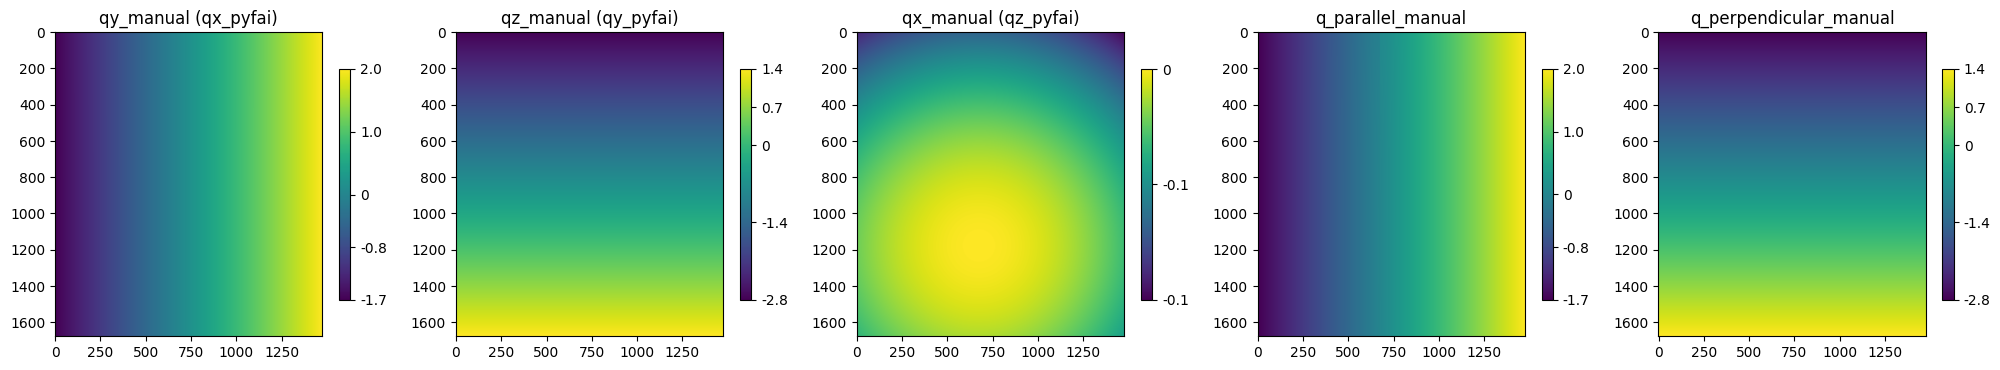

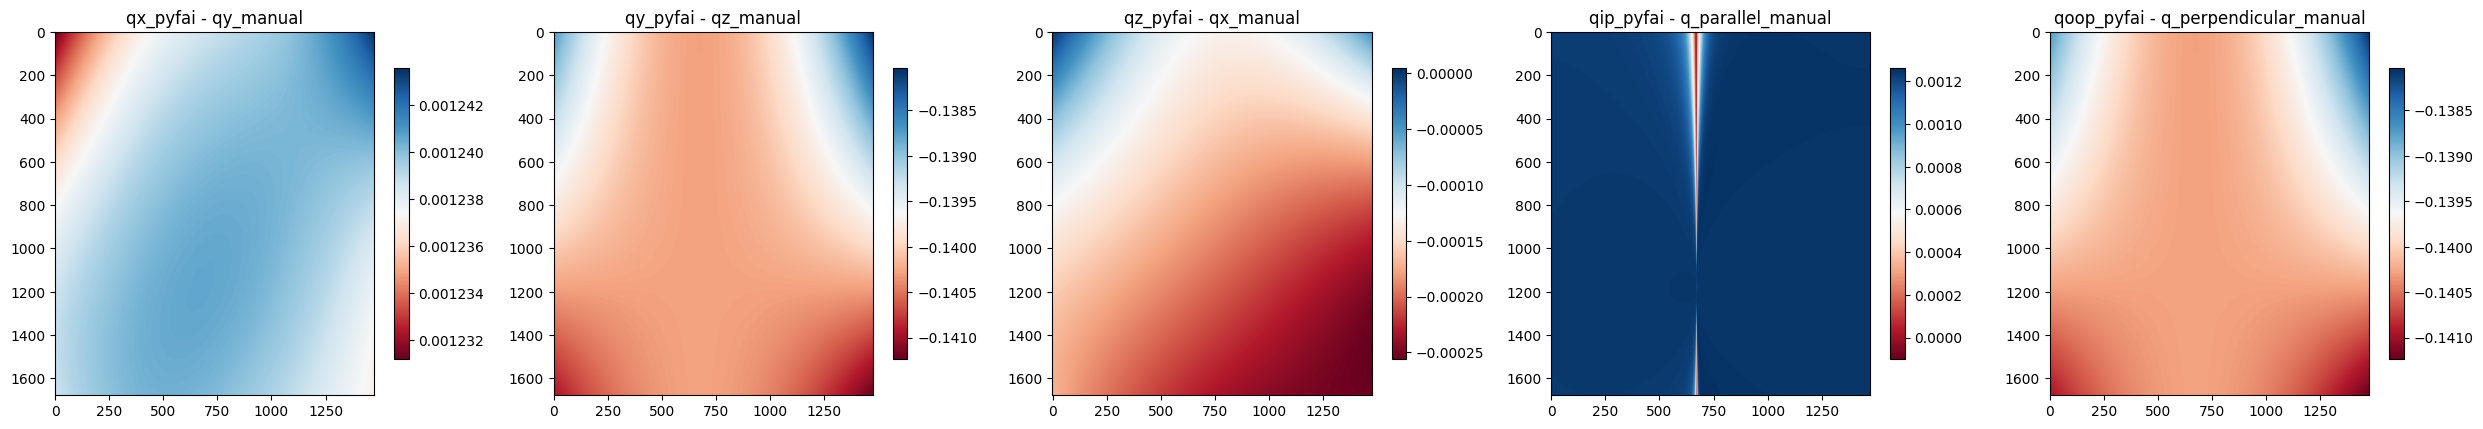

In [6]:
qx_pyfai = ai.array_from_unit(shape=masked_data.shape, unit="qxgi_nm^-1")
qy_pyfai = ai.array_from_unit(shape=masked_data.shape, unit="qygi_nm^-1")
qz_pyfai = ai.array_from_unit(shape=masked_data.shape, unit="qzgi_nm^-1")
qip_pyfai = ai.array_from_unit(shape=masked_data.shape, unit="qip_nm^-1")
qoop_pyfai = ai.array_from_unit(shape=masked_data.shape, unit="qoop_nm^-1")

plt.figure(figsize=(25, 10))
plt.subplot(1,5,1)
plt.imshow(qx_pyfai)
plt.title("qx_pyfai")
# colorbar and show the min and max values on the colorbar
cbar = plt.colorbar(shrink=0.3)
# cbar.ax.set_yticklabels([f"{v:.2f}" for v in np.linspace(qx_pyfai.min(), qx_pyfai.max(), 10)])
# cbar.ax.set_ylabel('qx_pyfai (1/nm)')
cbar.set_ticks([qx_pyfai.min(), 0.5*qx_pyfai.min(), 0, 0.5*qx_pyfai.max(), qx_pyfai.max()])
cbar.set_ticklabels([f"{qx_pyfai.min():.1f}", f"{qx_pyfai.min()/2:.1f}", 0, f"{qx_pyfai.max()/2:.1f}", f"{qx_pyfai.max():.1f}"])


plt.subplot(1,5,2)
plt.imshow(qy_pyfai)
plt.title("qy_pyfai")
cbar = plt.colorbar(shrink=0.3)
cbar.set_ticks([qy_pyfai.min(), 0.5*qy_pyfai.min(), 0, 0.5*qy_pyfai.max(), qy_pyfai.max()])
cbar.set_ticklabels([f"{qy_pyfai.min():.1f}", f"{qy_pyfai.min()/2:.1f}", 0, f"{qy_pyfai.max()/2:.1f}", f"{qy_pyfai.max():.1f}"])



plt.subplot(1,5,3)
plt.imshow(qz_pyfai)
plt.title("qz_pyfai")
cbar = plt.colorbar(shrink=0.3)
# cbar.set_ticks([qz_pyfai.min(), 0.5*qz_pyfai.min(), 0, 0.5*qz_pyfai.max(), qz_pyfai.max()])
# cbar.set_ticklabels([f"{qz_pyfai.min():.2f}", f"{qz_pyfai.min()/2:.2f}", 0, f"{qz_pyfai.max()/2:.2f}", f"{qz_pyfai.max():.2f}"])
cbar.set_ticks([qz_pyfai.min(), 0.5*qz_pyfai.min(), 0])
cbar.set_ticklabels([f"{qz_pyfai.min():.1f}", f"{qz_pyfai.min()/2:.1f}", 0])


plt.subplot(1,5,4)
plt.imshow(qip_pyfai)
plt.title("qip_pyfai")
cbar = plt.colorbar(shrink=0.3)
cbar.set_ticks([qip_pyfai.min(), 0.5*qip_pyfai.min(), 0, 0.5*qip_pyfai.max(), qip_pyfai.max()])
cbar.set_ticklabels([f"{qip_pyfai.min():.1f}", f"{qip_pyfai.min()/2:.1f}", 0, f"{qip_pyfai.max()/2:.1f}", f"{qip_pyfai.max():.1f}"])

plt.subplot(1,5,5)
plt.imshow(qoop_pyfai)
plt.title("qoop_pyfai")
cbar = plt.colorbar(shrink=0.3)
cbar.set_ticks([qoop_pyfai.min(), 0.5*qoop_pyfai.min(), 0, 0.5*qoop_pyfai.max(), qoop_pyfai.max()])
cbar.set_ticklabels([f"{qoop_pyfai.min():.1f}", f"{qoop_pyfai.min()/2:.1f}", 0, f"{qoop_pyfai.max()/2:.1f}", f"{qoop_pyfai.max():.1f}"])
plt.show()

plt.figure(figsize=(25, 10))
plt.subplot(1,5,1)
plt.imshow(q_y)
plt.title("qy_manual (qx_pyfai)")
cbar = plt.colorbar(shrink=0.3)
cbar.set_ticks([q_y.min(), 0.5*q_y.min(), 0, 0.5*q_y.max(), q_y.max()])
cbar.set_ticklabels([f"{q_y.min():.1f}", f"{q_y.min()/2:.1f}", 0, f"{q_y.max()/2:.1f}", f"{q_y.max():.1f}"])

plt.subplot(1,5,2)
plt.imshow(q_z)
plt.title("qz_manual (qy_pyfai)")
cbar = plt.colorbar(shrink=0.3)
cbar.set_ticks([q_z.min(), 0.5*q_z.min(), 0, 0.5*q_z.max(), q_z.max()])
cbar.set_ticklabels([f"{q_z.min():.1f}", f"{q_z.min()/2:.1f}", 0, f"{q_z.max()/2:.1f}", f"{q_z.max():.1f}"])

plt.subplot(1,5,3)
plt.imshow(q_x)
plt.title("qx_manual (qz_pyfai)")
cbar = plt.colorbar(shrink=0.3)
# cbar.set_ticks([q_x.min(), 0.5*q_x.min(), 0, 0.5*q_x.max(), q_x.max()])
# cbar.set_ticklabels([f"{q_x.min():.2f}", f"{q_x.min()/2:.2f}", 0, f"{q_x.max()/2:.2f}", f"{q_x.max():.2f}"])
cbar.set_ticks([q_x.min(), 0.5*q_x.min(), 0])
cbar.set_ticklabels([f"{q_x.min():.1f}", f"{q_x.min()/2:.1f}", 0])

plt.subplot(1,5,4)
plt.imshow(q_parallel)
plt.title("q_parallel_manual")
cbar = plt.colorbar(shrink=0.3)
cbar.set_ticks([q_parallel.min(), 0.5*q_parallel.min(), 0, 0.5*q_parallel.max(), q_parallel.max()])
cbar.set_ticklabels([f"{q_parallel.min():.1f}", f"{q_parallel.min()/2:.1f}", 0, f"{q_parallel.max()/2:.1f}", f"{q_parallel.max():.1f}"])

plt.subplot(1,5,5)
plt.imshow(q_perpendicular)
plt.title("q_perpendicular_manual")
cbar = plt.colorbar(shrink=0.3)
cbar.set_ticks([q_perpendicular.min(), 0.5*q_perpendicular.min(), 0, 0.5*q_perpendicular.max(), q_perpendicular.max()])
cbar.set_ticklabels([f"{q_perpendicular.min():.1f}", f"{q_perpendicular.min()/2:.1f}", 0, f"{q_perpendicular.max()/2:.1f}", f"{q_perpendicular.max():.1f}"])
plt.show()




# Compare the q values from pyFAI and manual calculation
plt.figure(figsize=(25, 10))
plt.subplot(1,5,1)
plt.imshow(qx_pyfai - q_y, cmap="RdBu")
plt.title("qx_pyfai - qy_manual")
plt.colorbar(shrink=0.3)

plt.subplot(1,5,2)
plt.imshow(qy_pyfai - q_z, cmap="RdBu")
plt.title("qy_pyfai - qz_manual")
plt.colorbar(shrink=0.3)

plt.subplot(1,5,3)
plt.imshow(qz_pyfai - q_x, cmap="RdBu")
plt.title("qz_pyfai - qx_manual")
plt.colorbar(shrink=0.3)

plt.subplot(1,5,4)
plt.imshow(qip_pyfai - q_parallel, cmap="RdBu")
plt.title("qip_pyfai - q_parallel_manual")
plt.colorbar(shrink=0.3)

plt.subplot(1,5,5)
plt.imshow(qoop_pyfai - q_perpendicular, cmap="RdBu")
plt.title("qoop_pyfai - q_perpendicular_manual")
plt.colorbar(shrink=0.3)

plt.tight_layout()
plt.show()


diff2 min: -0.1412371421081302
diff2 max: -0.138036558601891
vmax2: 0.1412371421081302


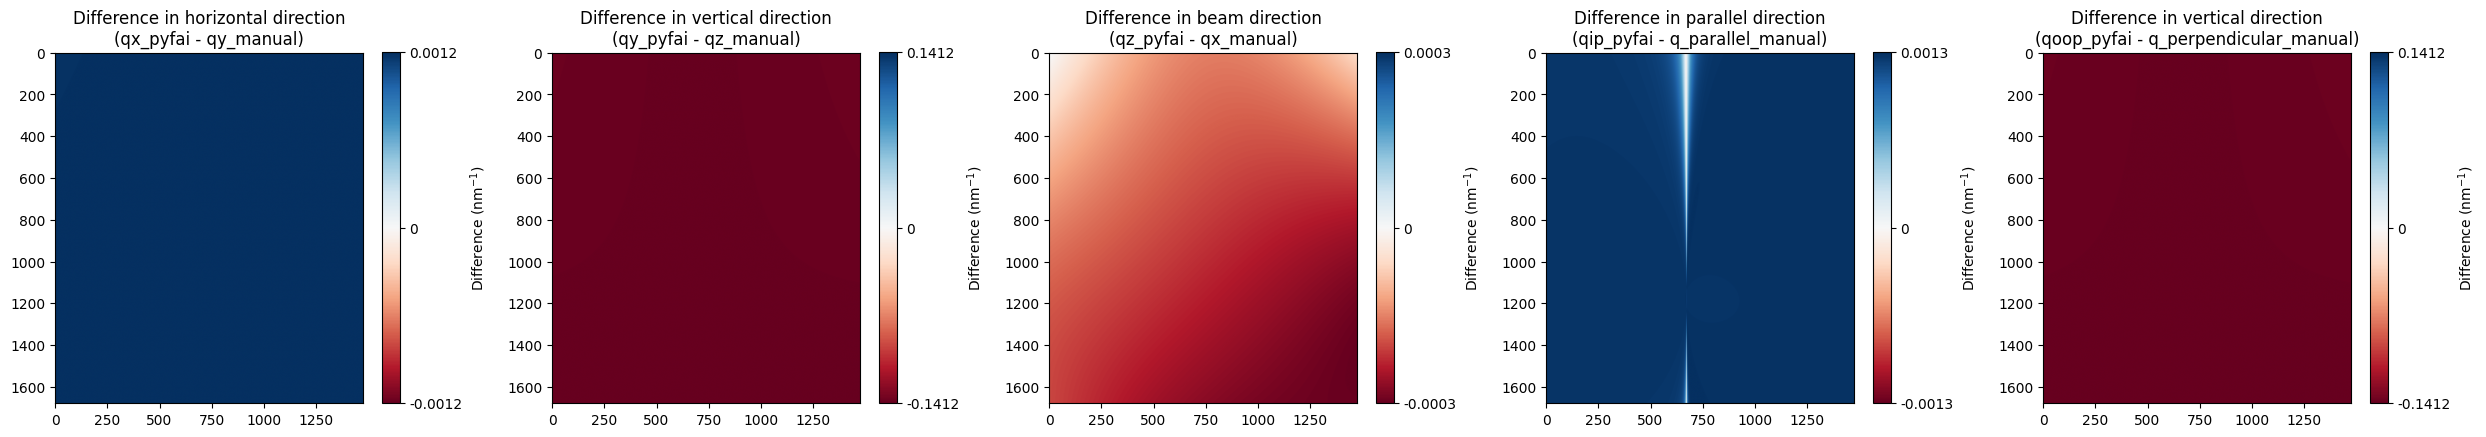

In [7]:
# Compare the q values from pyFAI and manual calculation
plt.figure(figsize=(25, 12))

# For each subplot, we'll set symmetric limits around zero
plt.subplot(1,5,1)
diff1 = qx_pyfai - q_y
vmax1 = max(abs(diff1.min()), abs(diff1.max()))
im1 = plt.imshow(diff1, cmap="RdBu", vmin=-vmax1, vmax=vmax1)
plt.title("Difference in horizontal direction\n(qx_pyfai - qy_manual)")
cbar1 = plt.colorbar(im1, shrink=0.3, label='Difference (nm$^{-1}$)')
cbar1.set_ticks([-vmax1, 0, vmax1])
cbar1.set_ticklabels([f"{-vmax1:.4f}", "0", f"{vmax1:.4f}"])

plt.subplot(1,5,2)
diff2 = qy_pyfai - q_z
vmax2 = max(abs(diff2.min()), abs(diff2.max()))
print("diff2 min:", diff2.min())
print("diff2 max:", diff2.max())
print("vmax2:", vmax2)
im2 = plt.imshow(diff2, cmap="RdBu", vmin=-vmax2, vmax=vmax2)
plt.title("Difference in vertical direction\n(qy_pyfai - qz_manual)")
cbar2 = plt.colorbar(im2, shrink=0.3, label='Difference (nm$^{-1}$)')
cbar2.set_ticks([-vmax2, 0, vmax2])
cbar2.set_ticklabels([f"{-vmax2:.4f}", "0", f"{vmax2:.4f}"])

plt.subplot(1,5,3)
diff3 = qz_pyfai - q_x
vmax3 = max(abs(diff3.min()), abs(diff3.max()))
im3 = plt.imshow(diff3, cmap="RdBu", vmin=-vmax3, vmax=vmax3)
plt.title("Difference in beam direction\n(qz_pyfai - qx_manual)")
cbar3 = plt.colorbar(im3, shrink=0.3, label='Difference (nm$^{-1}$)')
cbar3.set_ticks([-vmax3, 0, vmax3])
cbar3.set_ticklabels([f"{-vmax3:.4f}", "0", f"{vmax3:.4f}"])

plt.subplot(1,5,4)
diff4 = qip_pyfai - q_parallel
vmax4 = max(abs(diff4.min()), abs(diff4.max()))
im4 = plt.imshow(diff4, cmap="RdBu", vmin=-vmax4, vmax=vmax4)
plt.title("Difference in parallel direction\n(qip_pyfai - q_parallel_manual)")
cbar4 = plt.colorbar(im4, shrink=0.3, label='Difference (nm$^{-1}$)')
cbar4.set_ticks([-vmax4, 0, vmax4])
cbar4.set_ticklabels([f"{-vmax4:.4f}", "0", f"{vmax4:.4f}"])

plt.subplot(1,5,5)
diff5 = qoop_pyfai - q_perpendicular
vmax5 = max(abs(diff5.min()), abs(diff5.max()))
im5 = plt.imshow(diff5, cmap="RdBu", vmin=-vmax5, vmax=vmax5)
plt.title("Difference in vertical direction\n(qoop_pyfai - q_perpendicular_manual)")
cbar5 = plt.colorbar(im5, shrink=0.3, label='Difference (nm$^{-1}$)')
cbar5.set_ticks([-vmax5, 0, vmax5])
cbar5.set_ticklabels([f"{-vmax5:.4f}", "0", f"{vmax5:.4f}"])

plt.tight_layout()
plt.show()

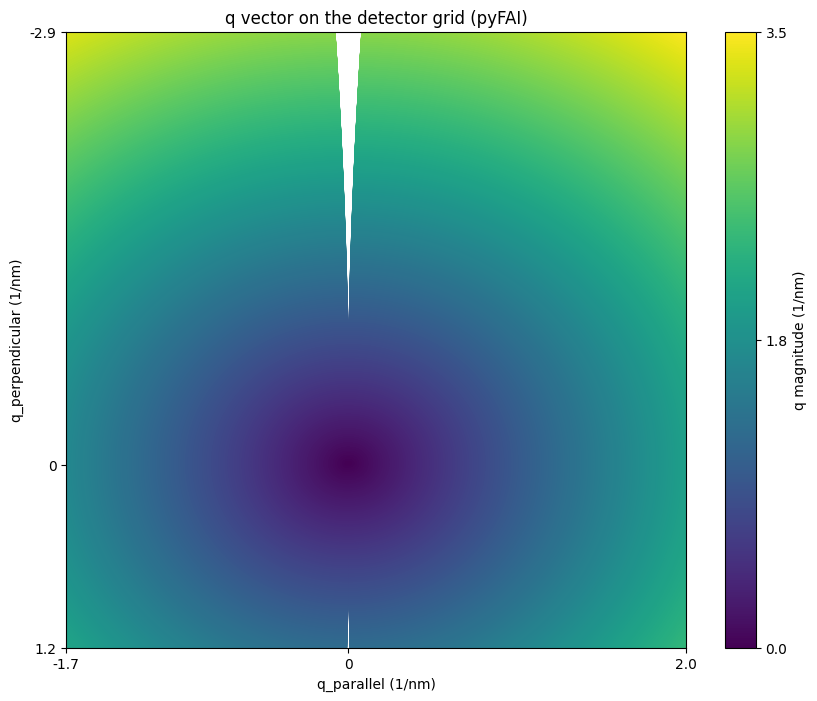

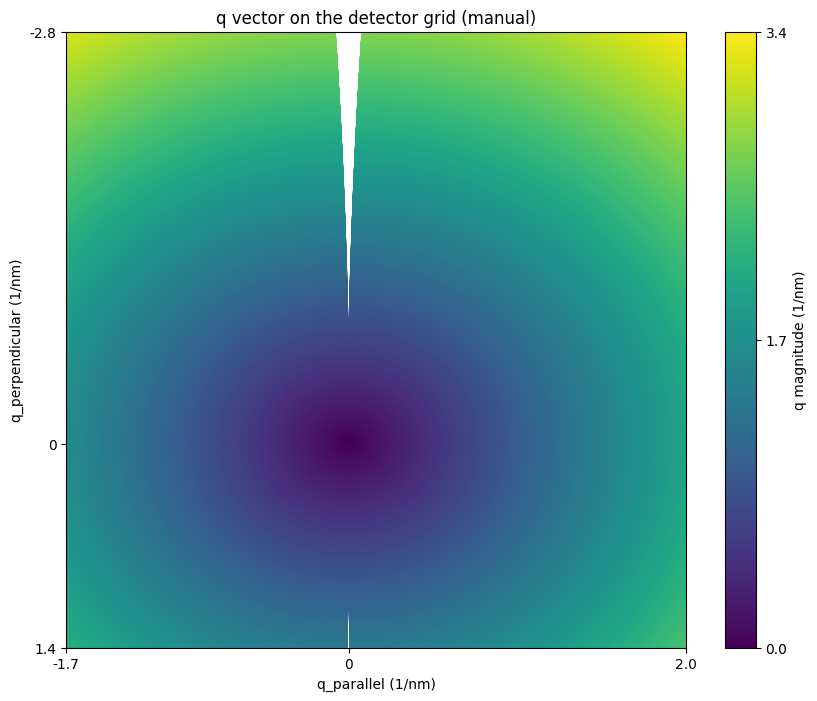

In [8]:
plt.figure(figsize=(10, 8))
q_total_pyfai = np.sqrt(qip_pyfai**2 + qoop_pyfai**2)

plt.scatter(qip_pyfai, qoop_pyfai, s=1, c=q_total_pyfai)
plt.title('q vector on the detector grid (pyFAI)')
plt.xlabel('q_parallel (1/nm)')
plt.ylabel('q_perpendicular (1/nm)')
cbar = plt.colorbar(label='q magnitude (1/nm)')
cbar.set_ticks([q_total_pyfai.min(), 0.5*q_total_pyfai.max(), q_total_pyfai.max()])
cbar.set_ticklabels([f"{q_total_pyfai.min():.1f}", f"{q_total_pyfai.max()/2:.1f}", f"{q_total_pyfai.max():.1f}"])
plt.xlim(qip_pyfai.min(), qip_pyfai.max())
plt.ylim(qoop_pyfai.max(), qoop_pyfai.min())

# Fix: Use numerical values for tick positions, then format the labels
min_qip = qip_pyfai.min()
max_qip = qip_pyfai.max()
min_qoop = qoop_pyfai.min()
max_qoop = qoop_pyfai.max()

plt.xticks([min_qip, 0, max_qip], [f"{min_qip:.1f}", "0", f"{max_qip:.1f}"])
plt.yticks([min_qoop, 0, max_qoop], [f"{min_qoop:.1f}", "0", f"{max_qoop:.1f}"])
plt.show()

# Plot the q vector on the detector grid with color based on q magnitude
plt.figure(figsize=(10, 8))
plt.scatter(q_parallel, q_perpendicular, s=1, c=q_mag, cmap='viridis')
cbar = plt.colorbar(label='q magnitude (1/nm)')
cbar.set_ticks([q_mag.min(), 0.5*q_mag.max(), q_mag.max()])
cbar.set_ticklabels([f"{q_mag.min():.1f}", f"{q_mag.max()/2:.1f}", f"{q_mag.max():.1f}"])
plt.title('q vector on the detector grid (manual)')
plt.xlabel('q_parallel (1/nm)')
plt.ylabel('q_perpendicular (1/nm)')
plt.xlim(q_parallel.min(), q_parallel.max())
plt.ylim(q_perpendicular.max(), q_perpendicular.min())

# Fix: Use numerical values for tick positions, then format the labels
min_qp = q_parallel.min()
max_qp = q_parallel.max()
min_qperp = q_perpendicular.min()
max_qperp = q_perpendicular.max()

plt.xticks([min_qp, 0, max_qp], [f"{min_qp:.1f}", "0", f"{max_qp:.1f}"])
plt.yticks([min_qperp, 0, max_qperp], [f"{min_qperp:.1f}", "0", f"{max_qperp:.1f}"])
plt.show()


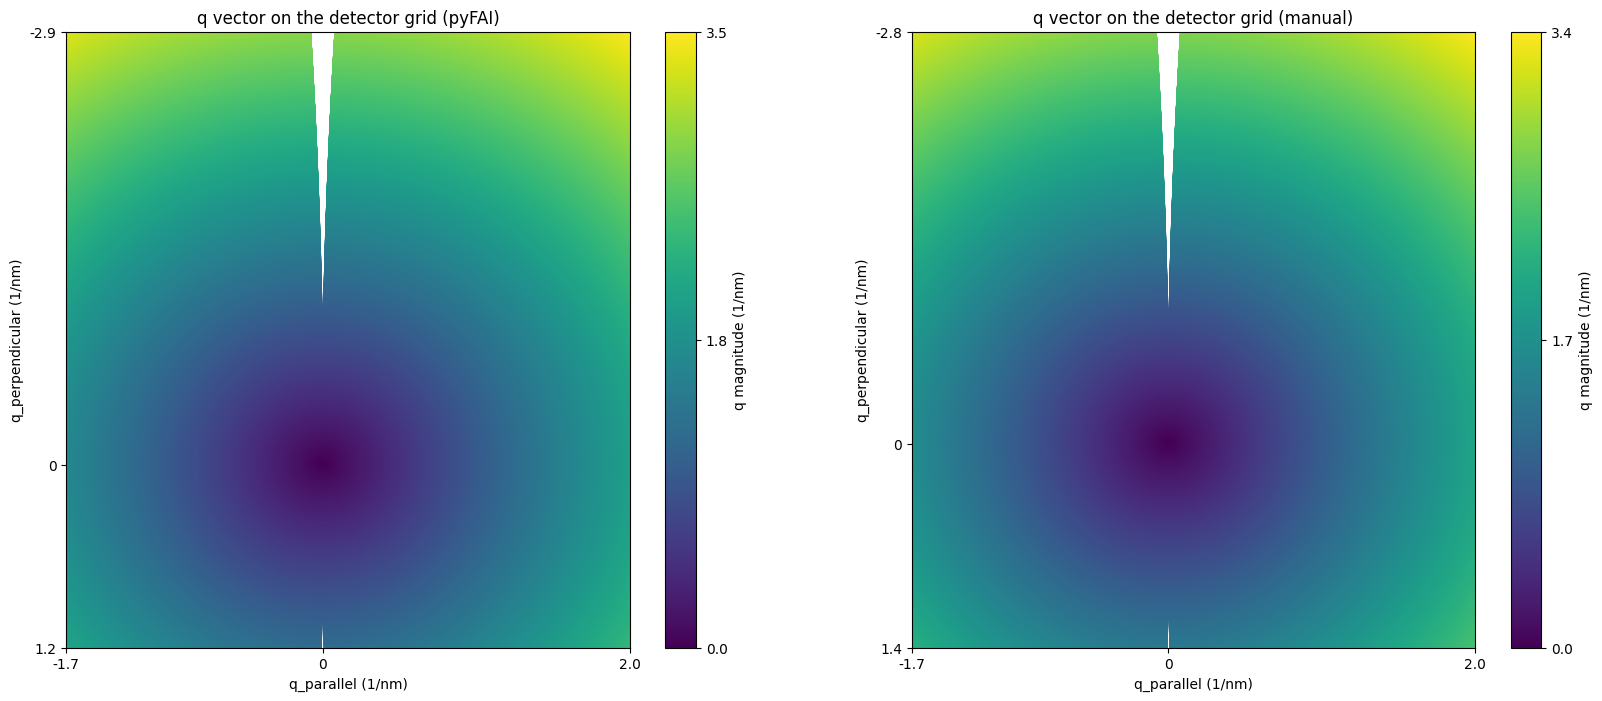

: 

In [ ]:
# Plot both figures side by side on a subplot
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.scatter(qip_pyfai, qoop_pyfai, s=1, c=q_total_pyfai)
plt.title('q vector on the detector grid (pyFAI)')
plt.xlabel('q_parallel (1/nm)')
plt.ylabel('q_perpendicular (1/nm)')
cbar = plt.colorbar(label='q magnitude (1/nm)')
cbar.set_ticks([q_total_pyfai.min(), 0.5*q_total_pyfai.max(), q_total_pyfai.max()])
cbar.set_ticklabels([f"{q_total_pyfai.min():.1f}", f"{q_total_pyfai.max()/2:.1f}", f"{q_total_pyfai.max():.1f}"])
plt.xlim(qip_pyfai.min(), qip_pyfai.max())
plt.ylim(qoop_pyfai.max(), qoop_pyfai.min())
# Fix: Use numerical values for tick positions, then format the labels
min_qip = qip_pyfai.min()
max_qip = qip_pyfai.max()
min_qoop = qoop_pyfai.min()
plt.xticks([min_qip, 0, max_qip], [f"{min_qip:.1f}", "0", f"{max_qip:.1f}"])
plt.yticks([min_qoop, 0, max_qoop], [f"{min_qoop:.1f}", "0", f"{max_qoop:.1f}"])
plt.subplot(1, 2, 2)
plt.scatter(q_parallel, q_perpendicular, s=1, c=q_mag, cmap='viridis')
cbar = plt.colorbar(label='q magnitude (1/nm)')
cbar.set_ticks([q_mag.min(), 0.5*q_mag.max(), q_mag.max()])
cbar.set_ticklabels([f"{q_mag.min():.1f}", f"{q_mag.max()/2:.1f}", f"{q_mag.max():.1f}"])
plt.title('q vector on the detector grid (manual)')
plt.xlabel('q_parallel (1/nm)')
plt.ylabel('q_perpendicular (1/nm)')
plt.xlim(q_parallel.min(), q_parallel.max())
plt.ylim(q_perpendicular.max(), q_perpendicular.min())
# Fix: Use numerical values for tick positions, then format the labels
min_qp = q_parallel.min()
max_qp = q_parallel.max()
min_qperp = q_perpendicular.min()
max_qperp = q_perpendicular.max()
plt.xticks([min_qp, 0, max_qp], [f"{min_qp:.1f}", "0", f"{max_qp:.1f}"])
plt.yticks([min_qperp, 0, max_qperp], [f"{min_qperp:.1f}", "0", f"{max_qperp:.1f}"])
plt.show()